# Representation with a Feature Cross

In this exercise, you'll experiment with different ways to represent features.

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/representation_with_a_feature_cross.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=representation_tf2-colab&hl=en

## Learning Objectives:

After doing this Colab, you'll know how to:

  * Use [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) methods to represent features in different ways.
  * Represent features as [bins](https://developers.google.com/machine-learning/glossary/#bucketing). 
  * Cross bins to create a [feature cross](https://developers.google.com/machine-learning/glossary/#feature_cross). 

## The Dataset
  
Like several of the previous Colabs, this exercise uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

In [7]:
import numpy as np
import pandas as pd
import logging
import tensorflow as tf
import tqdm.notebook as tqdm
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')
tf.get_logger().setLevel(logging.ERROR)
tf.__version__

'2.4.1'

## Load, scale, and shuffle the examples

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

The code cell then scales the `median_house_value` to a more human-friendly range and then suffles the examples.

In [8]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

## Represent latitude and longitude as floating-point values

Previous Colabs trained on only a single feature or a single synthetic feature. By contrast, this exercise trains on two features. Furthermore, this Colab introduces **feature columns**, which provide a sophisticated way to represent features.  

You create feature columns as possible:

  * Call a [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) method to represent a single feature, single feature cross, or single synthetic feature in the desired way.  For example, to represent a certain feature as floating-point values, call [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column). To represent a certain feature as a series of buckets or bins, call [`tf.feature_column.bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column).
  * Assemble the created representations into a Python list. 

A neighborhood's location is typically the most important feature in determining a house's value. The California Housing dataset provides two features, `latitude` and `longitude` that identify each neighborhood's location. 

The following code cell calls [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) twice, first to represent `latitude` as floating-point value and a second time to represent `longitude` as floating-point values. 

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `fp_feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 


In [9]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column("latitude")
feature_columns.append(latitude)

# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column("longitude")
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

When used, the layer processes the raw inputs, according to the transformations described by the feature columns, and packs the result into a numeric array.  (The model will train on this numeric array.) 

## Define functions that create and train a model, and a plotting function

The following code defines three functions:

  * `create_model`, which tells TensorFlow to build a linear regression model and to use the `feature_layer_as_fp` as the representation of the model's features.
  * `train_model`, which will ultimately train the model from training set examples.
  * `plot_the_loss_curve`, which generates a loss curve.

In [10]:
def create_model(my_learning_rate, feature_layer):
    """Create and compile a simple linear regression model."""
    model = tf.keras.models.Sequential()

    model.add(feature_layer)

    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name, verbose=1):
    """Feed a dataset into the model in order to train it."""

    features = {name: np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose)

    epochs = history.epoch
  
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]

    return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
    """Plot a curve of loss vs. epoch."""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
    plt.show()  

## Train the model with floating-point representations

The following code cell calls the functions you just created to train, plot, and evaluate a model.

Epoch 1/30
170/170 [==============================] - 0s 496us/step - loss: 32506.7611 - root_mean_squared_error: 175.3416
Epoch 2/30
170/170 [==============================] - 0s 667us/step - loss: 13775.2313 - root_mean_squared_error: 117.3563
Epoch 3/30
170/170 [==============================] - 0s 740us/step - loss: 13448.1706 - root_mean_squared_error: 115.9606
Epoch 4/30
170/170 [==============================] - 0s 729us/step - loss: 13441.9556 - root_mean_squared_error: 115.9357
Epoch 5/30
170/170 [==============================] - 0s 727us/step - loss: 13608.2061 - root_mean_squared_error: 116.6504
Epoch 6/30
170/170 [==============================] - 0s 715us/step - loss: 13496.5565 - root_mean_squared_error: 116.1710
Epoch 7/30
170/170 [==============================] - 0s 661us/step - loss: 13407.4014 - root_mean_squared_error: 115.7800
Epoch 8/30
170/170 [==============================] - 0s 753us/step - loss: 13442.2540 - root_mean_squared_error: 115.9375
Epoch 9/30
170/1

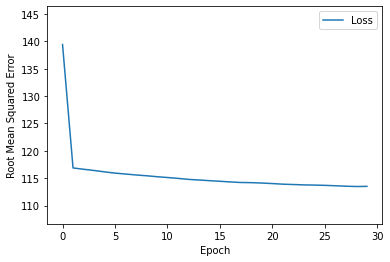


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 819us/step - loss: 12414.9775 - root_mean_squared_error: 111.4225


[12414.9775390625, 111.42251586914062]

In [11]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 1: Why aren't floating-point values a good way to represent latitude and longitude?

Are floating-point values a good way to represent `latitude` and `longitude`? 

No. The target variable (house price) does not really depend on latitude or longitude in a continuous way. Clearly they do effect the house price, but representing them as continuous variables is not a good description for this problem.

## Represent latitude and longitude in buckets

The following code cell represents latitude and longitude in buckets (bins). Each bin represents all the neighborhoods within a single degree. For example,
neighborhoods at latitude 35.4 and 35.8 are in the same bucket, but neighborhoods in latitude 35.4 and 36.2 are in different buckets. 

The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the "35" bin", a different weight for neighborhoods in the "36" bin, and so on. This representation will create approximately 20 buckets:
 
  * 10 buckets for `latitude`. 
  * 10 buckets for `longitude`. 

In [12]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(
    np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)
feature_columns.append(latitude)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(
    np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
buckets_feature_layer = layers.DenseFeatures(feature_columns)

## Train the model with bucket representations

Run the following code cell to train the model with bucket representations rather than floating-point representations:

Epoch 1/35
170/170 [==============================] - 0s 664us/step - loss: 54562.0225 - root_mean_squared_error: 233.5567
Epoch 2/35
170/170 [==============================] - 0s 780us/step - loss: 45468.6377 - root_mean_squared_error: 213.2220
Epoch 3/35
170/170 [==============================] - 0s 672us/step - loss: 39961.4558 - root_mean_squared_error: 199.8852
Epoch 4/35
170/170 [==============================] - 0s 645us/step - loss: 34151.5499 - root_mean_squared_error: 184.7675
Epoch 5/35
170/170 [==============================] - 0s 589us/step - loss: 28821.6098 - root_mean_squared_error: 169.7302
Epoch 6/35
170/170 [==============================] - 0s 666us/step - loss: 23935.7088 - root_mean_squared_error: 154.6902
Epoch 7/35
170/170 [==============================] - 0s 749us/step - loss: 20615.7419 - root_mean_squared_error: 143.5285
Epoch 8/35
170/170 [==============================] - 0s 1ms/step - loss: 17282.3341 - root_mean_squared_error: 131.4436
Epoch 9/35
170/170

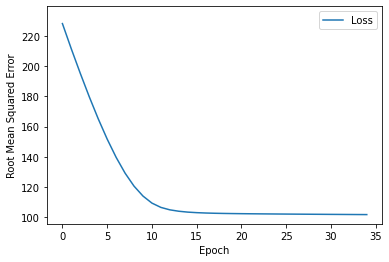


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 638us/step - loss: 10195.4473 - root_mean_squared_error: 100.9725


[10195.447265625, 100.97250366210938]

In [13]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 2: Did buckets outperform floating-point representations?

Compare the model's `root_mean_squared_error` values for the two representations (floating-point vs. buckets)?  Which model produced lower losses? 

## Task 3: What is a better way to represent location?

Buckets are a big improvement over floating-point values. Can you identify an even better way to identify location with `latitude` and `longitude`?

Yes: Feature cross. latitude and longitude indivdually are not that predictive, since there are many locations of the same latitude that have vastly different house prices. Since we are using only a linear model it can't do much with this.

## Represent location as a feature cross

The following code cell represents location as a feature cross. That is, the following code cell first creates buckets and then calls `tf.feature_column.crossed_column` to cross the buckets.



In [14]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/35
170/170 [==============================] - 1s 1ms/step - loss: 55169.5360 - root_mean_squared_error: 234.8614
Epoch 2/35
170/170 [==============================] - 0s 1ms/step - loss: 51235.7064 - root_mean_squared_error: 226.3063
Epoch 3/35
170/170 [==============================] - 0s 1ms/step - loss: 45466.7741 - root_mean_squared_error: 213.2106
Epoch 4/35
170/170 [==============================] - 0s 1ms/step - loss: 40681.7182 - root_mean_squared_error: 201.6896
Epoch 5/35
170/170 [==============================] - 0s 1ms/step - loss: 36188.3409 - root_mean_squared_error: 190.2189
Epoch 6/35
170/170 [==============================] - 0s 1ms/step - loss: 32680.9088 - root_mean_squared_error: 180.7709
Epoch 7/35
170/170 [==============================] - 0s 1ms/step - loss: 28731.8682 - root_mean_squared_error: 169.4974
Epoch 8/35
170/170 [==============================] - 0s 1ms/step - loss: 26216.4203 - root_mean_squared_error: 161.8992
Epoch 9/35
170/170 [============

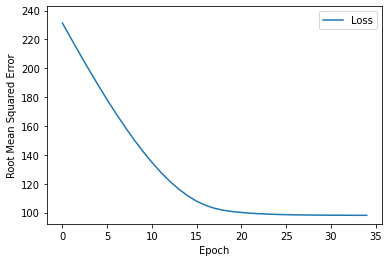


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 617us/step - loss: 9519.1162 - root_mean_squared_error: 97.5660


[9519.1162109375, 97.56595611572266]

In [16]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 4: Did the feature cross outperform buckets?

Compare the model's `root_mean_squared_error` values for the two representations (buckets vs. feature cross)?  Which model produced
lower losses? 

(test_loss, test_rmse) with bins: (10199.0732421875, 100.9904556274414) \
(test_loss, test_rmse) with feature cross: (9519.4443359375, 97.56764221191406)

So with feature cross was better.

## Task 5: Adjust the resolution of the feature cross

Return to the code cell in the "Represent location as a feature cross" section. Notice that `resolution_in_degrees` is set to 1.0. Therefore, each cell represents an area of 1.0 degree of latitude by 1.0 degree of longitude, which corresponds to a cell of 110 km by 90 km.  This resolution defines a rather large neighborhood. 

Experiment with `resolution_in_degrees` to answer the following questions:

  1. What value of `resolution_in_degrees` produces the best results (lowest loss value)?
  2. Why does loss increase when the value of `resolution_in_degrees` drops below a certain value?

Finally, answer the following question:

  3. What feature (that does not exist in the California Housing Dataset) would
     be a better proxy for location than latitude X longitude.

  0%|          | 0/4 [00:00<?, ?it/s]

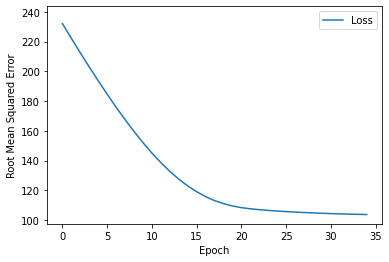


: Evaluate the new model against the test set:  0.1
30/30 [==============================] - 0s 633us/step - loss: 10523.4219 - root_mean_squared_error: 102.5837


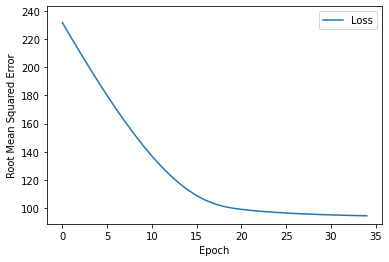


: Evaluate the new model against the test set:  0.5
30/30 [==============================] - 0s 721us/step - loss: 9010.9756 - root_mean_squared_error: 94.9262


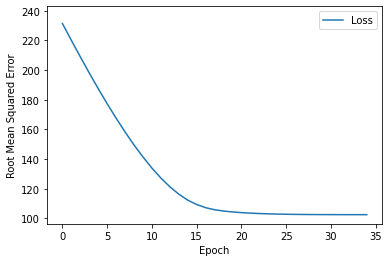


: Evaluate the new model against the test set:  2
30/30 [==============================] - 0s 630us/step - loss: 10220.2930 - root_mean_squared_error: 101.0955


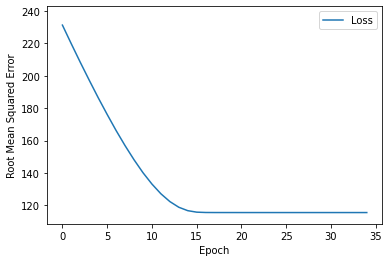


: Evaluate the new model against the test set:  10
30/30 [==============================] - 0s 2ms/step - loss: 12733.2578 - root_mean_squared_error: 112.8417


In [18]:
for resolution_in_degrees in tqdm.tqdm([0.1, 0.5, 2, 10]):
    feature_columns = []

    latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
    latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
    latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

    longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
    longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
    longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

    latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
    crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
    feature_columns.append(crossed_feature)

    feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

    learning_rate = 0.04
    epochs = 35

    my_model = create_model(learning_rate, feature_cross_feature_layer)

    epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name, verbose=0)

    plot_the_loss_curve(epochs, rmse)

    print("\n: Evaluate the new model against the test set: ", resolution_in_degrees)
    my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

* 0.5 gave the best results here
* < 0.1 is too fine grained for the model to learn anything

* Post code or Area descriptor e.g. city + area, etc.

We could also compute this mapping ourselves by scraping e.g. https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/